Course: Natural Language Processing

Name: OU YANG YU 

Submission Date: 11 April 2025

Problem: Identifying and Comparing Impact Factors (Deadweight, Displacement, Attribution, Drop-off) by designing and implementing a NLP solution to analyse the social value reports.

In [1]:
import os
import re
import string
import PyPDF2
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import Counter

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# ------------------------------
# DOWNLOAD RESOURCES
# ------------------------------
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thade\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\thade\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# ------------------------------
# SETUP: File Paths and Name Mapping
# ------------------------------
# Define the path to the folder where the SROI report PDFs are stored.
pdf_folder = "data"  # Folder containing the SROI PDF documents to be processed.

# Create a mapping dictionary to assign human-readable report names to PDF file names.
name_mapping = {
    "1.CTBC-Foundation-for-Arts-and-Culture-SROI-reportENGfinal.pdf": "Arts & Culture Report",
    "1.Six-Level-Redevelopment-Project-for-Traditional-Fishing-Villages-SROI-final.pdf": "Fishing Village Report",
    "4FoodforLifeLCsSROIFullReportv04.pdf": "Food for Life Report",
    "10d-LWTC-SROI-report-final_v04.pdf": "Diabetes Prevention Report",
    "1.CTBC-Baseball-SROI-Report.1211-1.pdf": "Baseball Sponsorship Report"
}

In [3]:
# ------------------------------
# FUNCTION: Extract Text from PDF
# ------------------------------
def extract_text_from_pdf(pdf_path):
    """Extract all text from a PDF file using PyPDF2.

    Args:
        pdf_path (str): Path to the PDF file.

    Returns:
        str: Combined text content from all pages in the PDF.
    """
    text = ""
    try:
        with open(pdf_path, "rb") as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page in pdf_reader.pages:
                extracted = page.extract_text()
                if extracted:
                    text += extracted + "\n"
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text


# ------------------------------
# FUNCTION: Clean Text
# ------------------------------
def clean_text(text):
    """Clean raw text for NLP processing.

    This includes:
    - Lowercasing
    - Removing digits
    - Removing punctuation
    - Removing extra whitespace

    Args:
        text (str): The raw input text.

    Returns:
        str: Cleaned text.
    """
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text


# ------------------------------
# FUNCTION: Tokenize Text
# ------------------------------
def tokenize_text(text, remove_stopwords=True):
    """Tokenize input text and optionally remove stopwords.

    Args:
        text (str): The text to tokenize.
        remove_stopwords (bool): Whether to remove common English stopwords.

    Returns:
        list: List of tokenized words.
    """
    tokens = word_tokenize(text)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    return tokens


# ------------------------------
# FUNCTION: Named Entity Recognition (NER) in Chunks
# ------------------------------
def extract_entities_chunked(text, chunk_size=10000):
    """Perform Named Entity Recognition (NER) on text using spaCy in manageable chunks.

    Args:
        text (str): The input text.
        chunk_size (int): The size of each chunk for processing.

    Returns:
        list: A list of tuples (entity_text, entity_label).
    """
    entities = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        doc = nlp(chunk)
        entities.extend([(ent.text, ent.label_) for ent in doc.ents])
    return entities


# ------------------------------
# FUNCTION: Entity Counts
# ------------------------------
def entity_counts(entities):
    """Count the number of entities per label.

    Args:
        entities (list): List of (entity_text, entity_label) tuples.

    Returns:
        dict: Dictionary of label counts.
    """
    return dict(Counter([label for (_, label) in entities]))


# ------------------------------
# FUNCTION: Extract SROI Ratio
# ------------------------------
def extract_sroi_modified(text):
    """Extract SROI (Social Return on Investment) value from unstructured text using regex.

    Handles multiple formats:
    - "SROI = 2.5 : 1"
    - "$3 per $1"
    - "2.5 to 1"
    - "SROI 2.5"

    Args:
        text (str): The input text.

    Returns:
        float or np.nan: Parsed SROI value or NaN if not found.
    """
    match_ratio = re.search(r'SROI(?: ratio)?[\s]*=?(?:[\s]*|[\w\s]+)\b(\d+(?:\.\d+)?)\s*:\s*(\d+(?:\.\d+)?)', text, re.IGNORECASE)
    if match_ratio:
        try:
            return float(match_ratio.group(1)) / float(match_ratio.group(2)) if float(match_ratio.group(2)) != 0 else np.nan
        except ValueError:
            pass

    match_per_unit = re.search(r'(?:[£\$]|NT\$)[\s]*(\d+(?:\.\d+)?)(?:[\s\w]+)(?:per|for every)[\s]*([£\$]|NT\$)?[\s]*1\b', text, re.IGNORECASE)
    if match_per_unit:
        return float(match_per_unit.group(1))

    match_one_colon = re.search(r'SROI(?: ratio)?[\s]*=?(?:[\s]*|[\w\s]+)\b1\s*:\s*(\d+(?:\.\d+)?)', text, re.IGNORECASE)
    if match_one_colon:
        return float(match_one_colon.group(1))

    match_to_one = re.search(r'(\d+(?:\.\d+)?)\s*(?:to)\s*1\b', text, re.IGNORECASE)
    if match_to_one:
        return float(match_to_one.group(1))

    match_sroi_direct = re.search(r'(?:Social Return on Investment|SROI)[\s\(]*SROI?[\s\)]*[\s]*(\d+(?:\.\d+)?)', text, re.IGNORECASE)
    if match_sroi_direct:
        return float(match_sroi_direct.group(1))

    return np.nan


# ------------------------------
# FUNCTION: Transformer-based Sentiment Analysis
# ------------------------------
def get_transformer_sentiment(text, tokenizer, sentiment_pipeline, max_tokens=128):
    """Analyze sentiment using a transformer-based pipeline by chunking text.

    Args:
        text (str): The input text.
        tokenizer: Hugging Face tokenizer.
        sentiment_pipeline: Hugging Face sentiment analysis pipeline.
        max_tokens (int): Maximum number of tokens per chunk.

    Returns:
        dict: Dictionary with overall sentiment label, average score, and number of chunks.
    """
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk_tokens = tokens[i:i+max_tokens]
        chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
        chunks.append(chunk_text)

    positive_scores = []
    for chunk in chunks:
        if chunk.strip() == "":
            continue
        result = sentiment_pipeline(chunk, truncation=True, max_length=max_tokens)[0]
        pos_score = result["score"] if result["label"].upper() == "POSITIVE" else 1 - result["score"]
        positive_scores.append(pos_score)

    overall_score = np.mean(positive_scores) if positive_scores else 0.5
    overall_label = "POSITIVE" if overall_score >= 0.5 else "NEGATIVE"
    
    return {
        "label": overall_label,
        "score": overall_score,
        "chunk_count": len(chunks)
    }


# ------------------------------
# FUNCTION: Extract SROI Impact Factors
# ------------------------------
def extract_impact_factors(text):
    """Extract and count the mentions of key SROI impact factors in text.

    The four key SROI impact factors:
    - Deadweight
    - Displacement
    - Attribution
    - Drop-off (and dropoff)

    Args:
        text (str): The input text.

    Returns:
        dict: A dictionary mapping factor names to their mention count.
    """
    factors = ["deadweight", "displacement", "attribution", "drop-off", "dropoff"]
    factor_counts = {}
    for factor in factors:
        count = len(re.findall(r'\b' + re.escape(factor) + r'\b', text, re.IGNORECASE))
        factor_counts[factor] = count
    return factor_counts


In [4]:
# ------------------------------
# DATA COLLECTION & PREPROCESSING
# ------------------------------

# Initialize an empty list to hold metadata and processed content for each PDF
data = []

# Loop through all files in the specified folder
for filename in os.listdir(pdf_folder):
    # Only process files that end with '.pdf' (case-insensitive)
    if filename.lower().endswith(".pdf"):
        file_path = os.path.join(pdf_folder, filename)  # Construct the full file path

        # Extract raw text from the PDF
        raw_text = extract_text_from_pdf(file_path)

        # Clean the text for further processing (e.g., remove punctuation, digits, and lowercasing)
        cleaned = clean_text(raw_text)

        # Tokenize the cleaned text into individual words
        tokens = tokenize_text(cleaned)

        # Count the number of tokens (i.e., word count)
        word_count = len(tokens)

        # Append a dictionary of collected and processed information to the data list
        data.append({
            "filename": filename,
            "raw_text": raw_text,
            "cleaned_text": cleaned,
            "tokens": tokens,
            "word_count": word_count
        })

# Convert the list of dictionaries into a pandas DataFrame for easier manipulation
df = pd.DataFrame(data)

# Add a more human-readable short name for each report based on a predefined mapping
df["short_name"] = df["filename"].map(name_mapping)

# Extract SROI metric (e.g., 3:1 ratio) from the raw text of each document
df["sroi"] = df["raw_text"].apply(extract_sroi_modified)

# Extract and count mentions of the four SROI impact factors from each raw text
df["impact_factors"] = df["raw_text"].apply(extract_impact_factors)

# ------------------------------
# OUTPUT: Summary and Preview
# ------------------------------

# Print a brief summary table showing key metrics for each report
print("\nDataset Information:")
print(df[['short_name', 'word_count', 'sroi', 'impact_factors']].to_string(index=False))

# Preview a snippet of cleaned text from the first document (useful for manual verification)
print("\nSample of cleaned text from the first file:")
print(df.iloc[0]['cleaned_text'][:500])  # Print first 500 characters of cleaned text



Dataset Information:
                 short_name  word_count  sroi                                                                         impact_factors
Baseball Sponsorship Report       17615 17.59 {'deadweight': 30, 'displacement': 15, 'attribution': 31, 'drop-off': 0, 'dropoff': 0}
      Arts & Culture Report       12800  4.18  {'deadweight': 40, 'displacement': 8, 'attribution': 35, 'drop-off': 0, 'dropoff': 0}
     Fishing Village Report       15134  1.91 {'deadweight': 15, 'displacement': 6, 'attribution': 13, 'drop-off': 16, 'dropoff': 0}
 Diabetes Prevention Report       19311  5.80  {'deadweight': 26, 'displacement': 9, 'attribution': 21, 'drop-off': 0, 'dropoff': 0}
       Food for Life Report       18644  4.40 {'deadweight': 20, 'displacement': 18, 'attribution': 20, 'drop-off': 0, 'dropoff': 0}

Sample of cleaned text from the first file:
social impact from ctbcs sponsorship of professional baseball social return on investment report december table of contents certificate

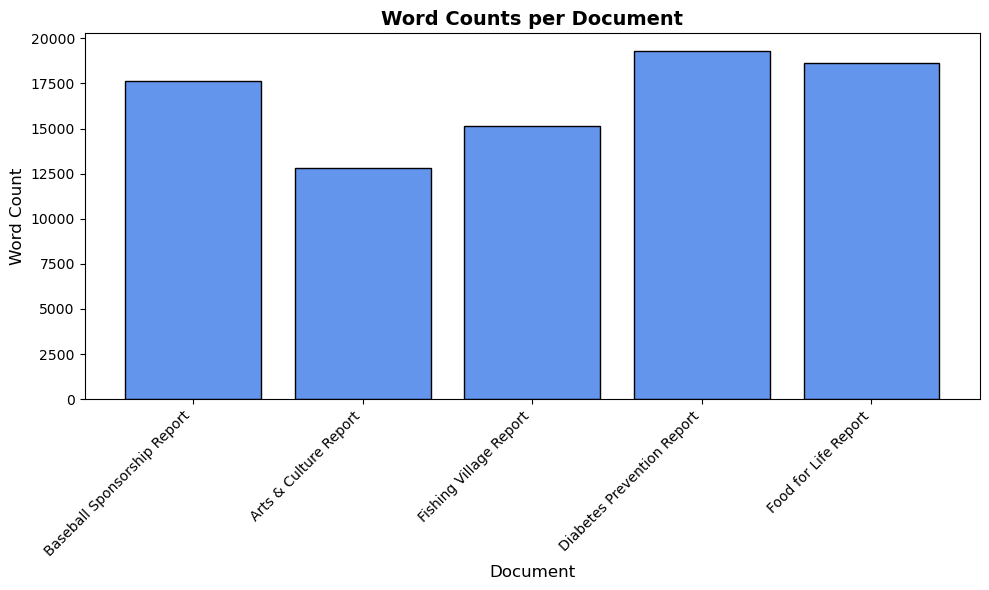

In [5]:
# ------------------------------
# EXPLORATORY VISUALIZATION: WORD COUNTS
# ------------------------------

# Create a new figure for the plot with a specific size
plt.figure(figsize=(10, 6))

# Create a bar chart to visualize word counts for each document
plt.bar(
    df['short_name'],             # X-axis: human-readable names of the documents
    df['word_count'],             # Y-axis: number of words in each document
    color='cornflowerblue',       # Set bar color for visual appeal
    edgecolor='black'             # Outline bars with black edges for better readability
)

# Label the X-axis and Y-axis
plt.xlabel("Document", fontsize=12)
plt.ylabel("Word Count", fontsize=12)

# Set a title for the plot
plt.title("Word Counts per Document", fontsize=14, fontweight='bold')

# Rotate x-axis labels for better visibility, especially if names are long
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout to prevent clipping of labels or title
plt.tight_layout()

# Display the plot
plt.show()



Shape of tfidf_matrix: (5, 1000)
Shape of tfidf_reduced: (5, 2)


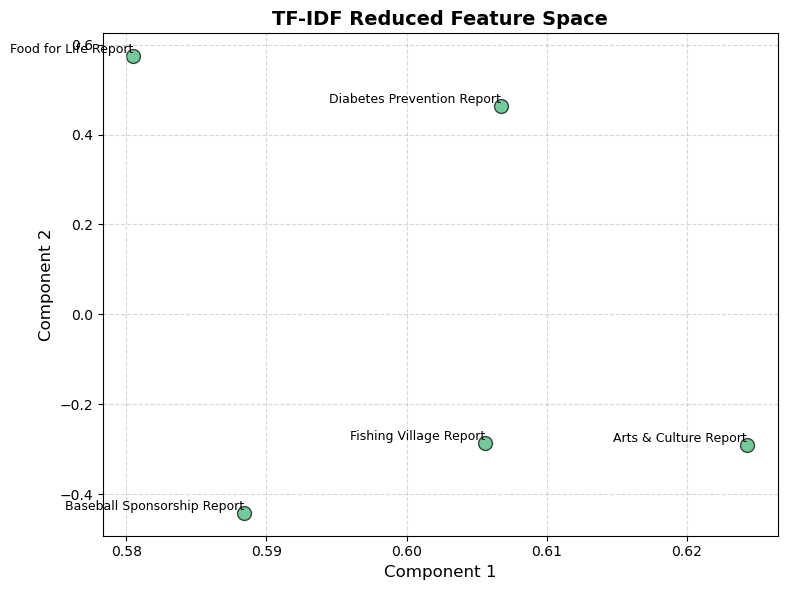

In [7]:
# ------------------------------
# FEATURE ENGINEERING: TF-IDF, SVD, and NMF
# ------------------------------

# Step 1: TF-IDF Vectorization
# Convert cleaned text into a numerical matrix using Term Frequency–Inverse Document Frequency (TF-IDF)
# Limit to 1000 features and exclude English stopwords
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Display shape of the resulting sparse matrix (documents x terms)
print(f"\nShape of tfidf_matrix: {tfidf_matrix.shape}")

# Step 2: Dimensionality Reduction with SVD
# Use Truncated SVD (a variant of PCA for sparse data) to reduce TF-IDF feature space to 2 components
svd = TruncatedSVD(n_components=2, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Display shape of the reduced matrix (documents x 2 components)
print(f"Shape of tfidf_reduced: {tfidf_reduced.shape}")

# Add the reduced components to the original dataframe for plotting
df['component_1'] = tfidf_reduced[:, 0]
df['component_2'] = tfidf_reduced[:, 1]

# Step 3: Visualization of Document Embeddings in Reduced Space
plt.figure(figsize=(8, 6))

# Plot each document in the 2D component space
plt.scatter(
    df['component_1'], df['component_2'],
    c='mediumseagreen', edgecolor='black', s=100, alpha=0.7
)

# Annotate each point with its document name for easy identification
for i, short_name in enumerate(df['short_name']):
    plt.annotate(short_name, (df['component_1'][i], df['component_2'][i]),
                 fontsize=9, ha='right', va='bottom')

# Add axis labels and a title
plt.xlabel("Component 1", fontsize=12)
plt.ylabel("Component 2", fontsize=12)
plt.title("TF-IDF Reduced Feature Space", fontsize=14, fontweight='bold')

# Add a subtle grid for better visual reference
plt.grid(True, linestyle='--', alpha=0.5)

# Optimize layout to prevent label clipping
plt.tight_layout()

# Display the plot
plt.show()



VADER Sentiment Scores:
                 short_name  vader_compound  vader_pos  vader_neu  vader_neg
Baseball Sponsorship Report        0.966089   0.129238   0.848540   0.022159
      Arts & Culture Report        0.944041   0.135283   0.840109   0.024500
     Fishing Village Report        0.952067   0.117216   0.860157   0.022627
 Diabetes Prevention Report        0.789599   0.098203   0.864739   0.037058
       Food for Life Report        0.961337   0.113839   0.870145   0.016065


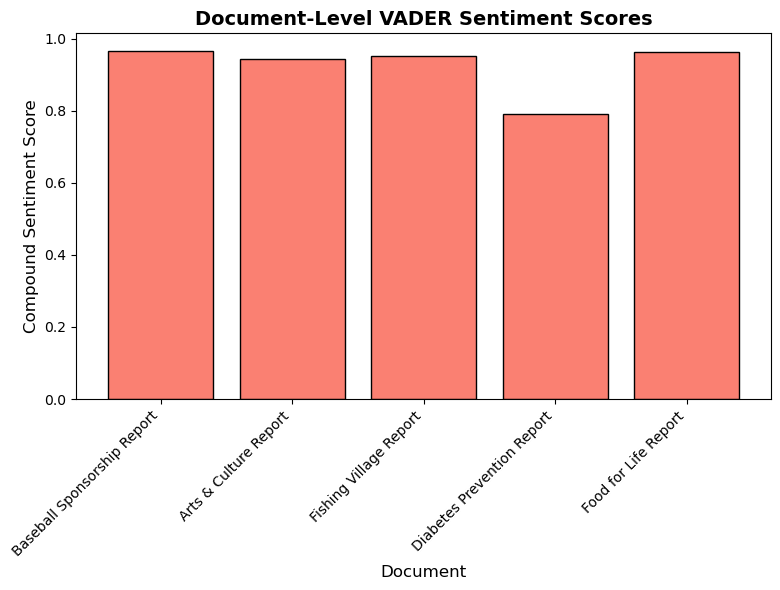

In [8]:
# ------------------------------
# VADER SENTIMENT ANALYSIS
# ------------------------------

# Initialize VADER sentiment analyzer from NLTK
sia = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text, chunk_length=500):
    """
    Analyze sentiment of a long text using VADER by dividing it into smaller chunks.

    Args:
        text (str): The input text to be analyzed.
        chunk_length (int): Number of words per chunk. Default is 500.

    Returns:
        dict: Dictionary with averaged compound, positive, neutral, and negative sentiment scores.
    """
    # Split text into individual words
    words = text.split()

    # Create overlapping or separate chunks of specified word count
    chunks = [' '.join(words[i:i+chunk_length]) for i in range(0, len(words), chunk_length)]

    # Calculate VADER sentiment for each chunk
    scores = [sia.polarity_scores(chunk) for chunk in chunks if chunk.strip()]

    # Average the sentiment scores across all chunks
    compound = np.mean([s['compound'] for s in scores])
    pos = np.mean([s['pos'] for s in scores])
    neu = np.mean([s['neu'] for s in scores])
    neg = np.mean([s['neg'] for s in scores])

    return {
        "compound": compound,
        "pos": pos,
        "neu": neu,
        "neg": neg
    }

# Apply the sentiment analysis function to each document in the DataFrame
# Store the full result dictionary in a new column
df["vader_improved"] = df["raw_text"].apply(lambda t: analyze_sentiment_vader(t, chunk_length=500))

# Extract and store each individual sentiment score in separate columns for analysis
df["vader_compound"] = df["vader_improved"].apply(lambda x: x["compound"])
df["vader_pos"] = df["vader_improved"].apply(lambda x: x["pos"])
df["vader_neu"] = df["vader_improved"].apply(lambda x: x["neu"])
df["vader_neg"] = df["vader_improved"].apply(lambda x: x["neg"])

# ------------------------------
# OUTPUT: Print Sentiment Scores
# ------------------------------
print("\nVADER Sentiment Scores:")
print(df[['short_name', 'vader_compound', 'vader_pos', 'vader_neu', 'vader_neg']].to_string(index=False))

# ------------------------------
# VISUALIZATION: VADER Sentiment Scores
# ------------------------------

# Plot a bar chart of compound sentiment scores for each document
plt.figure(figsize=(8, 6))
plt.bar(df['short_name'], df['vader_compound'], color='salmon', edgecolor='black')

# Add axis labels and title
plt.xlabel("Document", fontsize=12)
plt.ylabel("Compound Sentiment Score", fontsize=12)
plt.title("Document-Level VADER Sentiment Scores", fontsize=14, fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Optimize layout and display the plot
plt.tight_layout()
plt.show()


In [9]:
# ------------------------------
# TRANSFORMER-BASED SENTIMENT ANALYSIS (Chunk-based)
# ------------------------------

# Initialize a Hugging Face sentiment analysis pipeline
# This uses a transformer model under the hood (default: DistilBERT or similar)
sentiment_pipeline = pipeline("sentiment-analysis")

# Load the BERT tokenizer (used to split text into tokens compatible with the transformer model)
tokenizer_transformer = BertTokenizer.from_pretrained("bert-base-uncased")

# Apply the custom transformer sentiment analysis function to each raw document text
# The function splits text into chunks (max_tokens=128), runs each through the sentiment model,
# and averages the results
df["transformer_improved"] = df["raw_text"].apply(
    lambda t: get_transformer_sentiment(
        t, tokenizer_transformer, sentiment_pipeline, max_tokens=128
    )
)

# Extract individual components of the output:
# - Overall sentiment label (POSITIVE or NEGATIVE)
df["transformer_label"] = df["transformer_improved"].apply(lambda x: x["label"])

# - Average sentiment score across all chunks (confidence score)
df["transformer_score"] = df["transformer_improved"].apply(lambda x: x["score"])

# - Number of chunks used for analysis (useful to assess text length and coverage)
df["transformer_chunks"] = df["transformer_improved"].apply(lambda x: x["chunk_count"])

# ------------------------------
# OUTPUT: Display Sentiment Results
# ------------------------------

# Print a summary of sentiment classification for each document
print("\nTransformer-Based Sentiment Analysis Results (Chunk-based):")
print(df[['short_name', 'transformer_label', 'transformer_score', 'transformer_chunks']].to_string(index=False))


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Transformer-Based Sentiment Analysis Results (Chunk-based):
                 short_name transformer_label  transformer_score  transformer_chunks
Baseball Sponsorship Report          NEGATIVE           0.375564                 375
      Arts & Culture Report          POSITIVE           0.514757                 254
     Fishing Village Report          NEGATIVE           0.465855                 295
 Diabetes Prevention Report          NEGATIVE           0.289055                 341
       Food for Life Report          NEGATIVE           0.445365                 359



Entity Recognition Summary Table:
                             CARDINAL  DATE  EVENT  FAC  GPE  LAW  LOC  MONEY  \
short_name                                                                      
Baseball Sponsorship Report       654   191     11   32   56   28    6    259   
Arts & Culture Report             420   115      6    5   81    8    7     76   
Fishing Village Report            934   111     11   20   52    8   17     16   
Diabetes Prevention Report        815   385      2    3  115   20   30     63   
Food for Life Report              535   335      3    4  140    4    4    158   

                             NORP  ORDINAL  ORG  PERCENT  PERSON  PRODUCT  \
short_name                                                                  
Baseball Sponsorship Report     7       21  466      518      38       11   
Arts & Culture Report          18       11  381      215      53       11   
Fishing Village Report         27       28  274      368     154       13   
Diabetes Pre

C:\Users\thade\AppData\Local\Temp\ipykernel_13756\569996843.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entity_counts_df = entity_counts_df.fillna(0).astype(int)


<Figure size 1200x600 with 0 Axes>

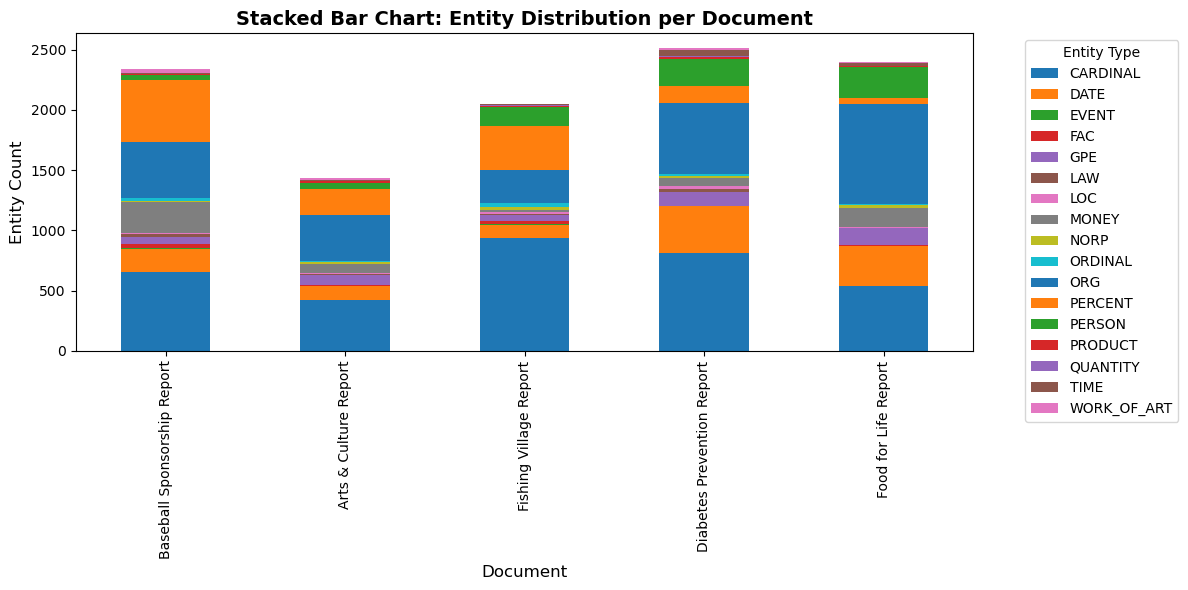


Top 5 Entities per Document:
Baseball Sponsorship Report:
   CARDINAL: 654
   PERCENT: 518
   ORG: 466
   MONEY: 259
   DATE: 191

Arts & Culture Report:
   CARDINAL: 420
   ORG: 381
   PERCENT: 215
   DATE: 115
   GPE: 81

Fishing Village Report:
   CARDINAL: 934
   PERCENT: 368
   ORG: 274
   PERSON: 154
   DATE: 111

Diabetes Prevention Report:
   CARDINAL: 815
   ORG: 582
   DATE: 385
   PERSON: 226
   PERCENT: 145

Food for Life Report:
   ORG: 833
   CARDINAL: 535
   DATE: 335
   PERSON: 254
   MONEY: 158



In [10]:
# ------------------------------
# ENTITY RECOGNITION WITH spaCy
# ------------------------------

# Load the large English language model from spaCy (includes word vectors and full NER capabilities)
nlp = spacy.load("en_core_web_lg")

# Apply chunked entity extraction to each raw document text using the pre-defined helper function
df["entities"] = df["raw_text"].apply(lambda t: extract_entities_chunked(t, chunk_size=10000))

# Count the number of occurrences of each entity label (e.g., PERSON, ORG, GPE) per document
df["entity_counts"] = df["entities"].apply(entity_counts)

# Collect all unique entity types found across all documents
all_entity_types = set()
for ec in df["entity_counts"]:
    all_entity_types.update(ec.keys())
all_entity_types = sorted(list(all_entity_types))  # Sort for consistent ordering

# ------------------------------
# Build a DataFrame for Entity Count Visualization
# ------------------------------

# Create a new DataFrame with documents as rows and entity types as columns
entity_counts_df = pd.DataFrame(index=df["short_name"], columns=all_entity_types)

# Fill in the DataFrame with actual counts (default to 0 if entity type is missing in a doc)
for idx, row in df.iterrows():
    counts = row["entity_counts"]
    for et in all_entity_types:
        entity_counts_df.loc[row["short_name"], et] = counts.get(et, 0)

# Fill any missing values with 0 and convert counts to integers
entity_counts_df = entity_counts_df.fillna(0).astype(int)

# ------------------------------
# Print and Visualize Entity Count Summary
# ------------------------------

# Print tabular summary of entity types per document
print("\nEntity Recognition Summary Table:")
print(entity_counts_df)

# Create a stacked bar chart to show distribution of entity types across documents
plt.figure(figsize=(12, 6))
entity_counts_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel("Document", fontsize=12)
plt.ylabel("Entity Count", fontsize=12)
plt.title("Stacked Bar Chart: Entity Distribution per Document", fontsize=14, fontweight='bold')
plt.legend(title="Entity Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ------------------------------
# Print Top 5 Most Common Entities for Each Document
# ------------------------------

print("\nTop 5 Entities per Document:")
for idx, row in df.iterrows():
    short_name = row["short_name"]

    # Sort entity types by count (descending)
    sorted_entities = sorted(row["entity_counts"].items(), key=lambda x: x[1], reverse=True)
    top_5 = sorted_entities[:5]

    # Display results
    print(f"{short_name}:")
    for ent, count in top_5:
        print(f"   {ent}: {count}")
    print()



========== RESULTS FOR 1 TOPIC ==========

Top words per topic:
Topic 1: outcomes, dance, ffl, diabetes, outcome, project, stakeholders, value, baseball, changes

Document-Topic Distribution:
                             Topic 1
short_name                          
Baseball Sponsorship Report      1.0
Arts & Culture Report            1.0
Fishing Village Report           1.0
Diabetes Prevention Report       1.0
Food for Life Report             1.0


D:\ProgramData\anaconda3\envs\aib551\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


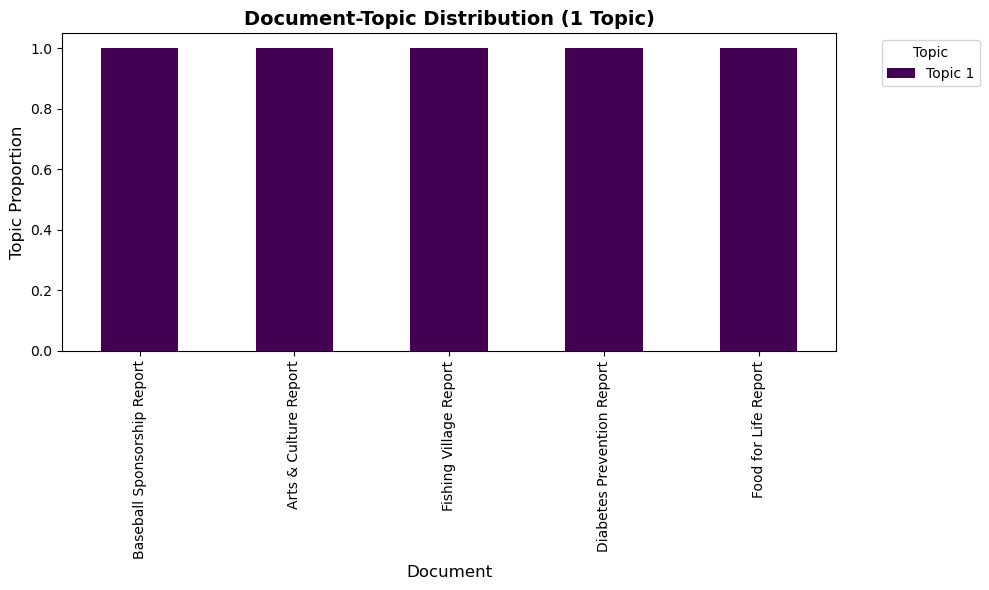


========== RESULTS FOR 5 TOPICS ==========

Top words per topic:
Topic 1: dance, arts, dancers, project, students, outcomes, bulareyaung, school, performance, company
Topic 2: ffl, food, kirklees, programme, catering, school, local, schools, staff, calderdale
Topic 3: aquaculture, fisher, milkfisherhome, outcome, fish, café, fishing, boren, investigator, fishermen
Topic 4: baseball, players, fans, ctbc, team, brothers, number, chinatrust, coaches, fan
Topic 5: diabetes, lwtc, participants, people, group, westbank, sroi, outcome, weight, gp

Document-Topic Distribution:
                              Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
short_name                                                                   
Baseball Sponsorship Report  0.000003  0.000000  0.000041  0.999893  0.000062
Arts & Culture Report        0.999998  0.000000  0.000000  0.000000  0.000002
Fishing Village Report       0.000000  0.000000  0.999986  0.000001  0.000012
Diabetes Prevention Report   0.00

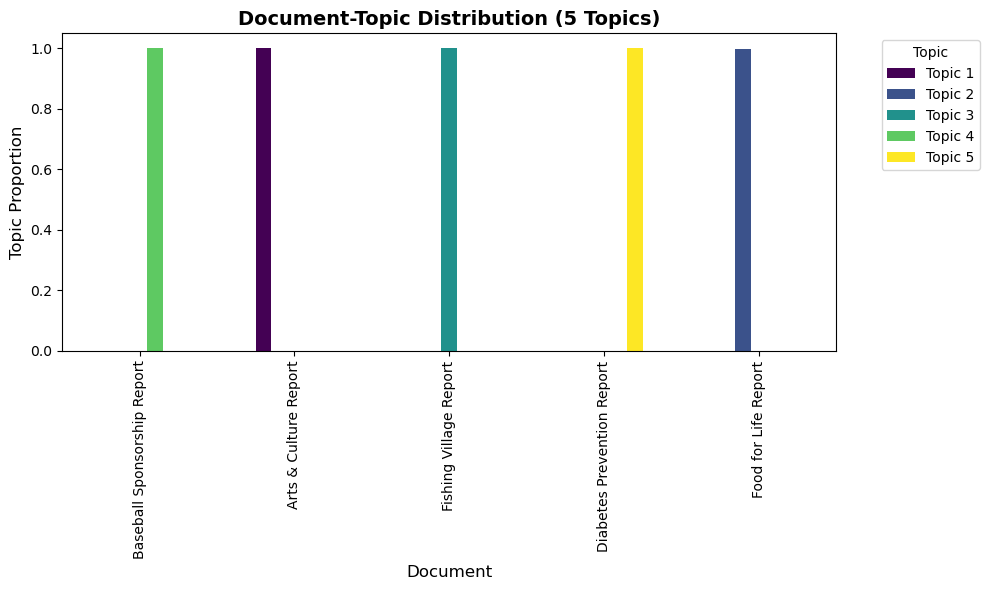

In [11]:
# ------------------------------
# TOPIC MODELLING WITH NMF (1 and 5-Topic Model)
# ------------------------------

# Iterate over two configurations: one-topic model and five-topic model
# Useful to compare coarse-grained vs. fine-grained topic separation
for num_topics in [1, 5]:
    print(f"\n========== RESULTS FOR {num_topics} TOPIC{'S' if num_topics > 1 else ''} ==========")
    
    # Step 1: Fit the NMF model on the TF-IDF matrix
    # - n_components sets the number of topics
    # - random_state ensures reproducibility
    nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=300)

    # W is the document-topic matrix (shape: num_docs x num_topics)
    W = nmf_model.fit_transform(tfidf_matrix)

    # H is the topic-word matrix (shape: num_topics x num_terms)
    H = nmf_model.components_

    # Step 2: Retrieve feature (term) names from the TF-IDF vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Step 3: Define a helper function to print top words for each topic
    def print_top_words(model, feature_names, n_top_words=10):
        for topic_idx, topic in enumerate(model.components_):
            top_indices = topic.argsort()[::-1][:n_top_words]  # Sort weights descending
            top_words = [feature_names[i] for i in top_indices]
            print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

    # Show top 10 words for each topic
    print("\nTop words per topic:")
    print_top_words(nmf_model, feature_names, n_top_words=10)

    # Step 4: Normalize W so each document’s topic distribution sums to 1
    doc_topic_distributions = W / W.sum(axis=1, keepdims=True)

    # Create a DataFrame for topic proportions per document
    doc_topic_df = pd.DataFrame(
        doc_topic_distributions,
        columns=[f"Topic {i+1}" for i in range(num_topics)],
        index=df["short_name"]
    )

    # Print document-topic distribution
    print("\nDocument-Topic Distribution:")
    print(doc_topic_df)

    # Step 5: Visualize the topic distribution for each document
    doc_topic_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.xlabel("Document", fontsize=12)
    plt.ylabel("Topic Proportion", fontsize=12)
    plt.title(f"Document-Topic Distribution ({num_topics} Topic{'s' if num_topics > 1 else ''})", fontsize=14, fontweight='bold')
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



Document Similarity Matrix:
short_name                   Baseball Sponsorship Report  \
short_name                                                 
Baseball Sponsorship Report                     1.000000   
Arts & Culture Report                           0.235392   
Fishing Village Report                          0.214104   
Diabetes Prevention Report                      0.180951   
Food for Life Report                            0.153107   

short_name                   Arts & Culture Report  Fishing Village Report  \
short_name                                                                   
Baseball Sponsorship Report               0.235392                0.214104   
Arts & Culture Report                     1.000000                0.231449   
Fishing Village Report                    0.231449                1.000000   
Diabetes Prevention Report                0.183806                0.199903   
Food for Life Report                      0.196511                0.167878   

sho

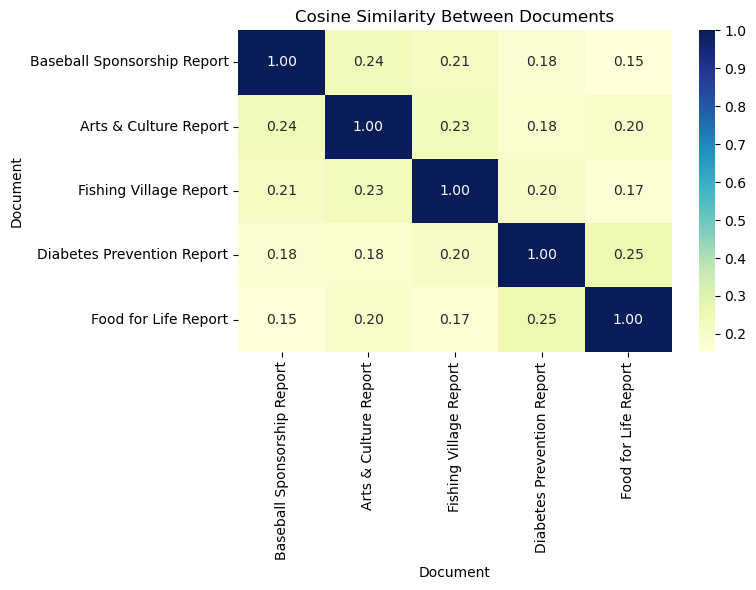


The most similar pair of documents is 'Diabetes Prevention Report' and 'Food for Life Report' with a similarity of 0.25.


In [12]:
# ------------------------------
# DOCUMENT SIMILARITY ANALYSIS
# ------------------------------

# Step 1: Compute Cosine Similarity between all document TF-IDF vectors
# Result is a symmetric matrix where each element (i,j) is the similarity between document i and j
similarity_matrix = cosine_similarity(tfidf_matrix)

# Convert the similarity matrix into a labeled DataFrame for easier inspection
similarity_df = pd.DataFrame(similarity_matrix, index=df["short_name"], columns=df["short_name"])

# Print the full similarity matrix
print("\nDocument Similarity Matrix:")
print(similarity_df)

# Step 2: Visualize the similarity matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap="YlGnBu", fmt=".2f")  # Show values with 2 decimal places
plt.title("Cosine Similarity Between Documents")
plt.xlabel("Document")
plt.ylabel("Document")
plt.tight_layout()
plt.show()

# Step 3: Identify the most similar pair of *different* documents (excluding diagonal)
# Make a copy of the similarity matrix to manipulate without affecting original
temp_sim = similarity_matrix.copy()

# Set diagonal elements (self-similarity) to -1 to ignore them when searching for max
np.fill_diagonal(temp_sim, -1)

# Find the indices of the maximum similarity score (i.e., most similar pair)
max_idx = np.unravel_index(np.argmax(temp_sim), temp_sim.shape)

# Retrieve the document names and similarity value
doc1 = df["short_name"].iloc[max_idx[0]]
doc2 = df["short_name"].iloc[max_idx[1]]
max_sim_value = similarity_matrix[max_idx]

# Output the most similar pair and their similarity score
print(f"\nThe most similar pair of documents is '{doc1}' and '{doc2}' with a similarity of {max_sim_value:.2f}.")



Actionable Insights Summary:
                      Document  Word Count  VADER Compound  Transformer Score  \
0  Baseball Sponsorship Report       17615        0.966089           0.375564   
3   Diabetes Prevention Report       19311        0.789599           0.289055   
4         Food for Life Report       18644        0.961337           0.445365   
1        Arts & Culture Report       12800        0.944041           0.514757   
2       Fishing Village Report       15134        0.952067           0.465855   

   SROI Metric  
0        17.59  
3         5.80  
4         4.40  
1         4.18  
2         1.91  

Correlation between VADER Compound and SROI Metric: 0.17
Correlation between Word Count and SROI Metric: 0.31
R Square between VADER Compound and SROI Metric: 0.03


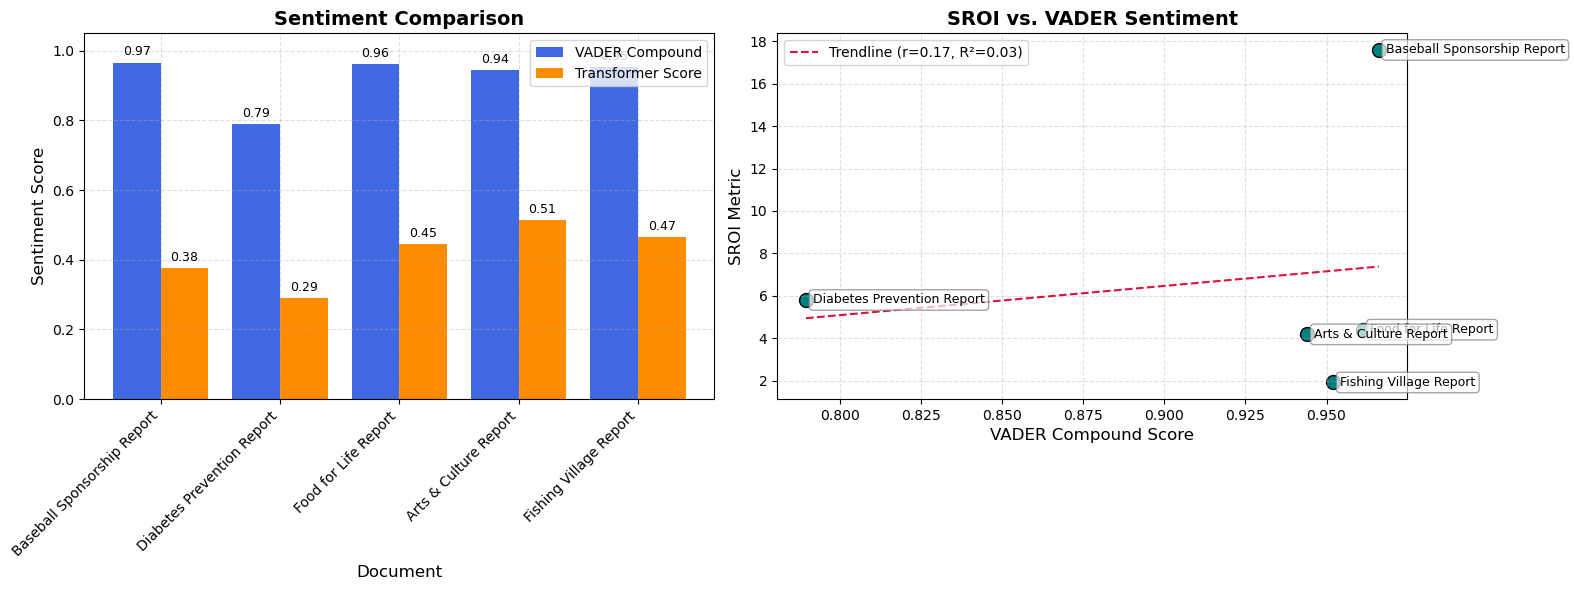


Impact Factors Count (Deadweight, Displacement, Attribution, Drop-off):
Baseball Sponsorship Report: {'deadweight': 30, 'displacement': 15, 'attribution': 31, 'drop-off': 0, 'dropoff': 0}
Arts & Culture Report: {'deadweight': 40, 'displacement': 8, 'attribution': 35, 'drop-off': 0, 'dropoff': 0}
Fishing Village Report: {'deadweight': 15, 'displacement': 6, 'attribution': 13, 'drop-off': 16, 'dropoff': 0}
Diabetes Prevention Report: {'deadweight': 26, 'displacement': 9, 'attribution': 21, 'drop-off': 0, 'dropoff': 0}
Food for Life Report: {'deadweight': 20, 'displacement': 18, 'attribution': 20, 'drop-off': 0, 'dropoff': 0}


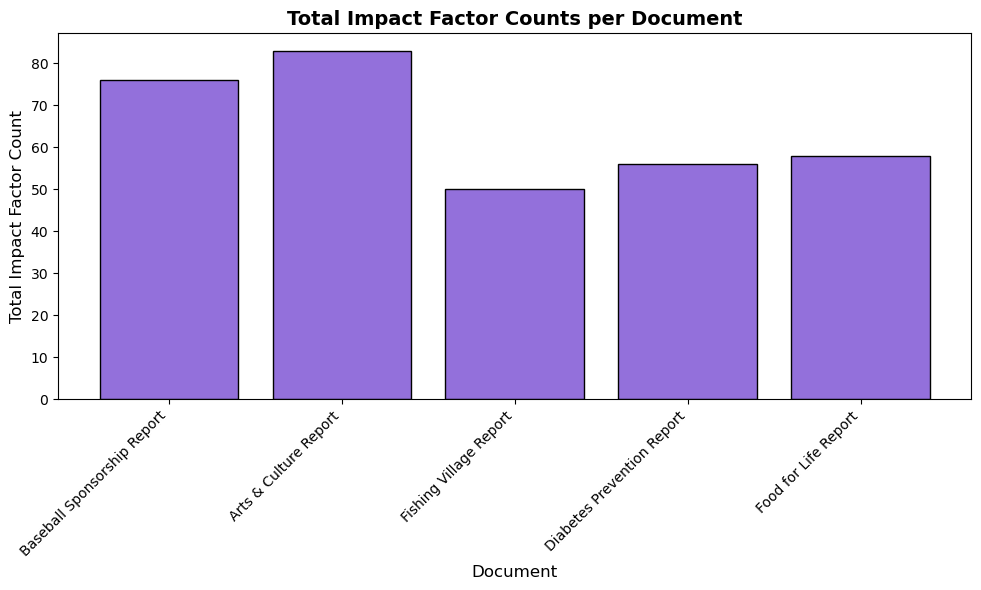


Correlation between Total Impact Factor Count and SROI Metric: 0.49

Full Correlation Matrix (Impact Factors and SROI):
              deadweight  displacement  attribution  drop_total  SROI
deadweight          1.00         -0.07         0.96       -0.65  0.31
displacement       -0.07          1.00         0.16       -0.57  0.48
attribution         0.96          0.16         1.00       -0.69  0.51
drop_total         -0.65         -0.57        -0.69        1.00 -0.44
SROI                0.31          0.48         0.51       -0.44  1.00


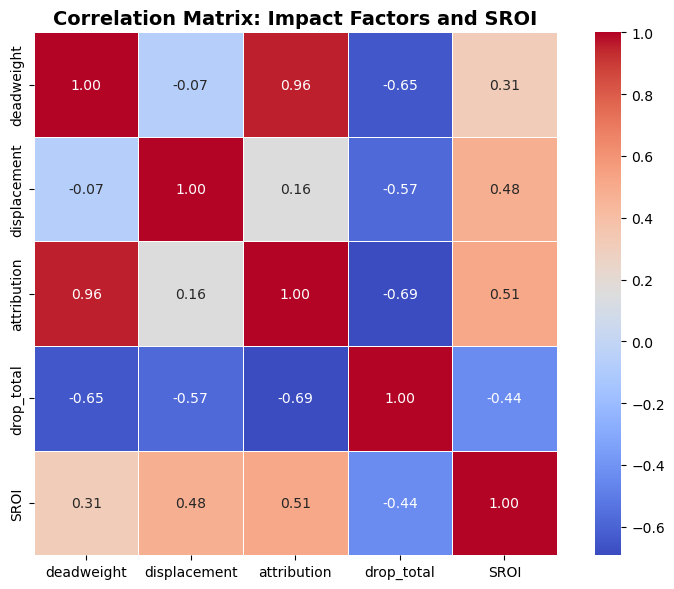

In [13]:
# ------------------------------
# ACTIONABLE INSIGHTS DASHBOARD & ADDITIONAL ANALYSIS
# ------------------------------

# Step 1: Create a summary DataFrame with selected key metrics
summary_df = pd.DataFrame({
    "Document": df["short_name"],
    "Word Count": df["word_count"],
    "VADER Compound": df["vader_compound"],
    "Transformer Score": df["transformer_score"],
    "SROI Metric": df["sroi"]
}).sort_values(by="SROI Metric", ascending=False)  # Sort to see highest SROI documents on top

# Print a concise summary table
print("\nActionable Insights Summary:")
print(summary_df)

# Step 2: Compute correlations if all SROI values are present
if summary_df["SROI Metric"].notna().all():
    # Correlation between VADER sentiment and SROI
    corr_vader_sroi = np.corrcoef(summary_df["VADER Compound"], summary_df["SROI Metric"])[0, 1]
    # Correlation between word count and SROI
    corr_wc_sroi = np.corrcoef(summary_df["Word Count"], summary_df["SROI Metric"])[0, 1]
    print(f"\nCorrelation between VADER Compound and SROI Metric: {corr_vader_sroi:.2f}")
    print(f"Correlation between Word Count and SROI Metric: {corr_wc_sroi:.2f}")
else:
    corr_vader_sroi = np.nan

# Step 3: Compute linear regression trendline for VADER vs SROI
m, b = np.polyfit(summary_df["VADER Compound"], summary_df["SROI Metric"], 1)
predicted = m * summary_df["VADER Compound"] + b
ss_res = np.sum((summary_df["SROI Metric"] - predicted) ** 2)
ss_tot = np.sum((summary_df["SROI Metric"] - np.mean(summary_df["SROI Metric"])) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R Square between VADER Compound and SROI Metric: {r_squared:.2f}")

# Step 4: Dual-panel visualization: Sentiment and SROI comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.3)

# --- Panel 1: Bar chart comparing VADER vs Transformer sentiment scores ---
labels = summary_df["Document"].values
x = np.arange(len(labels))
width = 0.4
axs[0].set_title("Sentiment Comparison", fontsize=14, fontweight='bold')
axs[0].set_xlabel("Document", fontsize=12)
axs[0].set_ylabel("Sentiment Score", fontsize=12)
axs[0].set_ylim([0, 1.05])

# Plot bars
bar_vader = axs[0].bar(x - width/2, summary_df["VADER Compound"], width, color="royalblue", label="VADER Compound")
bar_trans = axs[0].bar(x + width/2, summary_df["Transformer Score"], width, color="darkorange", label="Transformer Score")

# Annotate bars with values
for rect in bar_vader:
    height = rect.get_height()
    axs[0].annotate(f"{height:.2f}", (rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

for rect in bar_trans:
    height = rect.get_height()
    axs[0].annotate(f"{height:.2f}", (rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Configure ticks and grid
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.4)

# --- Panel 2: Scatter plot of VADER vs SROI with trendline ---
axs[1].set_title("SROI vs. VADER Sentiment", fontsize=14, fontweight='bold')
axs[1].set_xlabel("VADER Compound Score", fontsize=12)
axs[1].set_ylabel("SROI Metric", fontsize=12)

# Scatter plot
axs[1].scatter(summary_df["VADER Compound"], summary_df["SROI Metric"], s=100, color='teal', edgecolor='black')

# Annotate each point with document name
for i, doc in enumerate(labels):
    axs[1].annotate(doc, (summary_df["VADER Compound"].iloc[i], summary_df["SROI Metric"].iloc[i]),
                    fontsize=9, ha='left', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
                    xytext=(5, 0), textcoords='offset points')

# Add regression trendline
x_vals = np.linspace(summary_df["VADER Compound"].min(), summary_df["VADER Compound"].max(), 100)
axs[1].plot(x_vals, m * x_vals + b, color='crimson', linestyle='--',
            label=f"Trendline (r={corr_vader_sroi:.2f}, R²={r_squared:.2f})")

axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.4)

# Show both plots
plt.tight_layout()
plt.show()

# Step 5: Print out raw impact factor counts per document
print("\nImpact Factors Count (Deadweight, Displacement, Attribution, Drop-off):")
for idx, row in df.iterrows():
    print(f"{row['short_name']}: {row['impact_factors']}")

# Step 6: Calculate total mentions of impact factors (grouping both drop-off and dropoff)
def total_impact_factors(factor_dict):
    return (
        factor_dict.get("deadweight", 0)
        + factor_dict.get("displacement", 0)
        + factor_dict.get("attribution", 0)
        + factor_dict.get("drop-off", 0)
        + factor_dict.get("dropoff", 0)
    )

# Apply to dataframe
df["total_impact_factor"] = df["impact_factors"].apply(total_impact_factors)

# Plot total impact factor counts
plt.figure(figsize=(10, 6))
plt.bar(df["short_name"], df["total_impact_factor"], color='mediumpurple', edgecolor='black')
plt.xlabel("Document", fontsize=12)
plt.ylabel("Total Impact Factor Count", fontsize=12)
plt.title("Total Impact Factor Counts per Document", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# Correlation between impact factor count and SROI (if valid)
if df["sroi"].notna().all():
    corr_impact_sroi = np.corrcoef(df["total_impact_factor"], df["sroi"])[0, 1]
    print(f"\nCorrelation between Total Impact Factor Count and SROI Metric: {corr_impact_sroi:.2f}")

# -------------------------------------
# FULL CORRELATION MATRIX: Impact Factors + SROI
# -------------------------------------

# Step 1: Create a DataFrame of impact factors + SROI metric
impact_corr_df = pd.DataFrame(df["impact_factors"].tolist())
impact_corr_df["drop_total"] = impact_corr_df.get("drop-off", 0) + impact_corr_df.get("dropoff", 0)
impact_corr_df = impact_corr_df.drop(columns=["drop-off", "dropoff"], errors="ignore")
impact_corr_df["SROI"] = df["sroi"]

# Step 2: Compute Pearson correlation matrix
corr_matrix = impact_corr_df.corr(method="pearson")

# Step 3: Print correlation matrix
print("\nFull Correlation Matrix (Impact Factors and SROI):")
print(corr_matrix.round(2))

# Step 4: Visualize with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Matrix: Impact Factors and SROI", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
